# Using Latte with Pytorch Lightning

This example notebook demonstrates the use of [Latte](https://github.com/karnwatcharasupat/latte) with [PyTorch Lightning](https://www.pytorchlightning.ai/). 

The code in this notebook is adapted from the [AR-VAE](https://github.com/ashispati/ar-vae) implementation:
> A. Pati and A. Lerch, Attribute-based regularization of latent spaces for variational auto-encoders. Neural Computing & Applications, 33, 4429–4444 (2021). https://doi.org/10.1007/s00521-020-05270-2


For this notebook, we will be using the [Morpho-MNIST](https://github.com/dccastro/Morpho-MNIST) dataset which is a disentanglement dataset built on the usual MNIST dataset.

**Before you begin, please turn on GPU accelerator at `Runtime > Change runtime type > Hardware accelerator > GPU`.**

## Installing Latte and Dependencies

In [1]:
# This command automatically install PyTorch and TorchMetrics.
# For users with existing pytorch>=1.3.1 and torchmetrics>=0.2.0 installation, 
#   use `pip install latte-metrics` with no extras
!pip install latte-metrics[pytorch] --upgrade

# Pytorch Lightning is installed independently
!pip install pytorch-lightning

     |████████████████████████████████| 526 kB 16.9 MB/s            
  Using cached future-0.18.2-py3-none-any.whl
  Using cached pyDeprecate-0.3.1-py3-none-any.whl (10 kB)
  Using cached aiohttp-3.8.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.3 MB)
  Using cached frozenlist-1.2.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (210 kB)
  Using cached multidict-5.2.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (187 kB)


  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached yarl-1.7.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (308 kB)


## Preparing data

### Downloading dataset

In [10]:
%%bash

export DSET_PATH="/home/karn/data/" #"/content/dataset"
mkdir -p $DSET_PATH
gdown --id "1fFGJW0IHoBmLuD6CEKCB8jz3Y5LJ5Duk" -O $DSET_PATH/morphomnist.zip
unzip -o "$DSET_PATH/morphomnist.zip" -d $DSET_PATH

Archive:  /home/karn/data//morphomnist.zip
   creating: /home/karn/data/global/
 extracting: /home/karn/data/global/train-pert-idx1-ubyte.gz  
  inflating: /home/karn/data/global/train-images-idx3-ubyte.gz  
  inflating: /home/karn/data/global/train-morpho.csv  
 extracting: /home/karn/data/global/train-labels-idx1-ubyte.gz  
 extracting: /home/karn/data/global/t10k-pert-idx1-ubyte.gz  
  inflating: /home/karn/data/global/t10k-images-idx3-ubyte.gz  
  inflating: /home/karn/data/global/t10k-morpho.csv  
 extracting: /home/karn/data/global/t10k-labels-idx1-ubyte.gz  
  inflating: /home/karn/data/global/README-global.txt  


Downloading...
From: https://drive.google.com/uc?id=1fFGJW0IHoBmLuD6CEKCB8jz3Y5LJ5Duk
To: /home/karn/data/morphomnist.zip
100%|██████████| 15.5M/15.5M [00:00<00:00, 27.4MB/s]


### Cloning Morpho-MNIST measurement code

In [11]:
!cd ~ && git clone https://github.com/dccastro/Morpho-MNIST

Cloning into 'Morpho-MNIST'...
remote: Enumerating objects: 543, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 543 (delta 4), reused 7 (delta 3), pack-reused 531
Receiving objects: 100% (543/543), 154.91 KiB | 12.91 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [3]:
import os, sys
sys.path.append(os.path.os.path.expanduser('~/Morpho-MNIST'))

### Creating a LightningDataModule

In [73]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from morphomnist import io, morpho
import pytorch_lightning as pl

class MorphoMnistDataset(pl.LightningDataModule):

    def __init__(self, root_dir='/content/dataset/global', batch_size=128):
        super().__init__()
        self.kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
        self.root_dir = root_dir
        self.data_path_str = "-images-idx3-ubyte.gz"
        self.label_path_str = "-labels-idx1-ubyte.gz"
        self.morpho_path_str = "-morpho.csv"

        self.batch_size = batch_size

        self.train_dataset = self._create_dataset(dataset_type="train")
        self.val_dataset = self._create_dataset(dataset_type="t10k")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            **self.kwargs
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def _create_dataset(self, dataset_type):
        data_path = os.path.join(
            self.root_dir,
            dataset_type + self.data_path_str
        )
        morpho_path = os.path.join(
            self.root_dir,
            dataset_type + self.morpho_path_str
        )
        images = io.load_idx(data_path)
        images = np.expand_dims(images, axis=1).astype('float32') / 255.0
        morpho_labels = pd.read_csv(morpho_path).values.astype('float32')[:, 3:]
        dataset = TensorDataset(
            torch.from_numpy(images),
            torch.from_numpy(morpho_labels)
        )
        return dataset

## Creating a simple AR-VAE




### Defining the Loss Function

In [74]:
from torch.nn import functional as F

def ar_signed_loss(z, a, factor=10.0):

    n_attr = a.shape[-1]

    # compute latent distance matrix
    lc_dist_mat = z[:, None, :n_attr] - z[None, :, :n_attr]

    # compute attribute distance matrix
    attribute_dist_mat = a[:, None, ...] - a[None, :, :]

    # compute regularization loss
    lc_tanh = torch.tanh(lc_dist_mat * factor)
    attribute_sign = torch.sign(attribute_dist_mat)
    batch_size = z.shape[0]
    ar_loss = F.l1_loss(lc_tanh, attribute_sign.float(), reduction='sum')/(batch_size ** 2 - batch_size)

    return ar_loss

def compute_loss(x, xhat, zd, z0, z, a, beta=1.0, gamma=1.0):

    recon_loss = F.mse_loss(x, torch.sigmoid(xhat), reduction='sum')/z.shape[0]

    kld_loss = distributions.kl.kl_divergence(zd, z0).sum(-1).mean()

    ar_loss = ar_signed_loss(z, a)

    return {
        'loss': recon_loss + beta * kld_loss + gamma * ar_loss,
        'recon_loss': recon_loss,
        'kld_loss': kld_loss,
        'ar_loss': ar_loss
    }

### Defining base VAE class

In [75]:
from torch import nn, distributions
from latte.metrics.torch.bundles import DependencyAwareMutualInformationBundle

class ImageVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 784
        self.z_dim = 16
        self.inter_dim = 19
        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Conv2d(64, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.Conv2d(64, 8, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
        )
        self.enc_lin = nn.Sequential(
            nn.Linear(2888, 256),
            nn.SELU()
        )
        self.enc_mean = nn.Linear(256, self.z_dim)
        self.enc_log_std = nn.Linear(256, self.z_dim)
        self.dec_lin = nn.Sequential(
            nn.Linear(self.z_dim, 256),
            nn.SELU(),
            nn.Linear(256, 2888),
            nn.SELU()
        )
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(8, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(64, 64, 4, 1),
            nn.SELU(),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(64, 1, 4, 1),
        )

        self.xavier_initialization()

    def xavier_initialization(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)

    def encode(self, x):
        hidden = self.enc_conv(x)
        hidden = hidden.view(x.size(0), -1)
        hidden = self.enc_lin(hidden)
        z_mean = self.enc_mean(hidden)
        z_log_std = self.enc_log_std(hidden)
        z_distribution = distributions.Normal(loc=z_mean, scale=torch.exp(z_log_std) + 1e-16)
        return z_distribution

    def decode(self, z):
        hidden = self.dec_lin(z)
        hidden = hidden.view(z.size(0), -1, self.inter_dim, self.inter_dim)
        hidden = self.dec_conv(hidden)
        return hidden

    def reparametrize(self, z_dist):
        # sample from distribution
        z_tilde = z_dist.rsample()

        # compute prior
        prior_dist = torch.distributions.Normal(
            loc=torch.zeros_like(z_dist.loc),
            scale=torch.ones_like(z_dist.scale)
        )
        return z_tilde, prior_dist

    def forward(self, x):
        # compute distribution using encoder
        z_dist = self.encode(x)

        # reparametrize
        z_tilde, prior_dist = self.reparametrize(z_dist)

        # compute output of decoding layer
        output = self.decode(z_tilde).view(x.size())

        return output, z_dist, prior_dist, z_tilde

### Convert the module into a LightningModule with Latte Metrics

See Latte documentation [here](https://latte.readthedocs.io/).

In [76]:
class ImageVAEwithLatte(pl.LightningModule, ImageVAE):
    def __init__(self):
        super().__init__()
        # define metrics here
        self.dami = DependencyAwareMutualInformationBundle(reg_dim=range(4))

    def training_step(self, data, idx):
        inputs, attributes = data

        recon, z_dist, prior_dist, z_tilde = self(inputs)

        loss = compute_loss(
            inputs, recon, z_dist, prior_dist, z_tilde, attributes
        )

        self.log_dict({f"train/{k}": loss[k] for k in loss}, prog_bar=True)
        
#         self.dami.update(z_tilde, attributes)
#         train_metrics = self.dami.compute()
#         self.dami.reset()

#         # Morpho-MNIST has 7 attributes. 
#         # Each metric has shape (7,) 
#         #   with each element representing the MIG for each attribute.
#         # We only put the mean metrics over the attributes here on the progress bar for demonstration
#         self.log_dict({f"train/{k}": train_metrics[k].mean() for k in train_metrics}, prog_bar=True)

        return loss['loss']

    def validation_step(self, data, idx):
        inputs, attributes = data

        recon, z_dist, prior_dist, z_tilde = self(inputs)

        loss = compute_loss(
            inputs, recon, z_dist, prior_dist, z_tilde, attributes
        )

#         self.dami.update(z_tilde, attributes)

        self.log_dict({f"val/{k}": loss[k] for k in loss}, prog_bar=True)

        return loss['loss']
        
#     def validation_epoch_end(self, outputs):
#         val_metrics = self.dami.compute()

#         # Morpho-MNIST has 7 attributes. 
#         # Each metric has shape (7,) 
#         #   with each element representing the MIG for each attribute.
#         # We only put the mean metrics over the attributes here on the progress bar for demonstration
#         self.log_dict({f"val/{k}": val_metrics[k].mean() for k in val_metrics}, prog_bar=True)

#         self.dami.reset()

    def configure_optimizers(self, lr=1e-4):
        return torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        return super().forward(x)

    def interpolate(self, x, dz):
        # compute distribution using encoder
        z_dist = self.encode(x)

        # reparametrize
        z_tilde, prior_dist = self.reparametrize(z_dist)

        # compute output of decoding layer

        if dz.ndim > 1:
            output = []
            for i in range(dz.shape[-1]):
                output.append(self.decode(z_tilde + dz[None, :, i]).view(x.size()))
            output = torch.stack(output, axis=-1)
        else:
            output = self.decode(z_tilde + dz[None, :]).view(x.size())

        return output

## Training the model

In [77]:
import latte

pl.seed_everything(42)

latte.seed(42) 
# there is no need for thisc
# this is just to demonstrate that you can manually set a seed
# Latte uses seed=42 by default anyway

model = ImageVAEwithLatte()
datamodule = MorphoMnistDataset(root_dir='/home/karn/data/global')

trainer = pl.Trainer(gpus=-1, max_epochs=100)

# this will take a while
trainer.fit(model, datamodule)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                                   | Params
-----------------------------------------------------------------------
0 | enc_conv    | Sequential                             | 74.9 K
1 | enc_lin     | Sequential                             | 739 K 
2 | enc_mean    | Linear                                 | 4.1 K 
3 | enc_log_std | Linear                                 | 4.1 K 
4 | dec_lin     | Sequential                             | 746 K 
5 | dec_conv    | Sequential                             | 74.9 K
6 | dami        | DependencyAwareMutualInformationBundle | 0     
-----------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.577     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# 
# HOME = '/content'
# HOME = '/home/karn/mir/latte/examples'
# trainer = pl.Trainer(resume_from_checkpoint=os.path.join(HOME, "morphomnist-pl-weights.ckpt"), max_epochs=101, gpus=-1)
# 

In [78]:
trainer.save_checkpoint("/home/karn/mir/latte/examples/morphomnist-pl-weights.ckpt")
torch.save(model.state_dict(), "/home/karn/mir/latte/examples/morphomnist-torch-weights.pth")

## Visualizing the outputs

In [101]:
atttribute_dict = {
    "thickness": 0,
    "slant": 1,
    "width": 2,
    "height": 3
}

In [108]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def interpolate_and_display(model, attribute):
    model.eval()
    model = model.cuda()
    
    f = plt.figure(figsize=(16, 16))
    ax = ImageGrid(
        f, 111,  # similar to subplot(111)
        nrows_ncols=(11, 8),  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    inputs, _ = datamodule.val_dataset[torch.randint(10000, (8,))]

    dz = torch.zeros((16, 10))
    dz[atttribute_dict[attribute], :] = torch.linspace(-2.0, 2.0, 10)

    gen = model.interpolate(inputs.cuda(), dz.cuda())
    gen = torch.sigmoid(gen)

    for i in range(8):
        ax[i].imshow(inputs.detach().cpu()[i, 0, :, :], cmap='summer')
        for j in range(10):
            ax[(j+1)*8+i].imshow(gen.detach().cpu()[i, 0, :, :, j], cmap='gray', vmin=0, vmax=1)
    
    for i in range(8*11):
        ax[i].axis('off')
    
    plt.show()

The top row is the original input images. The subsequent rows have the specified attribute changed in increasing order.

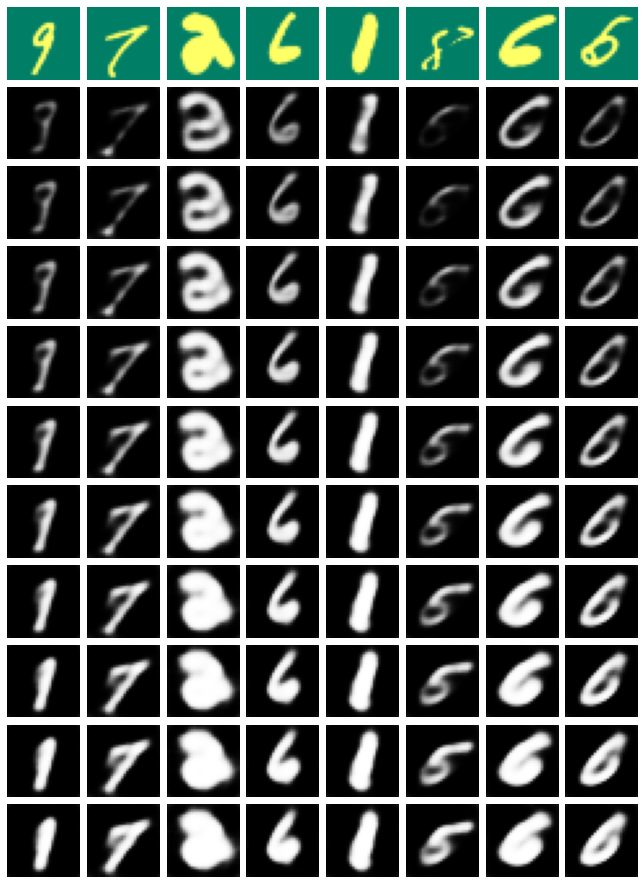

In [110]:
interpolate_and_display(model, 'thickness')

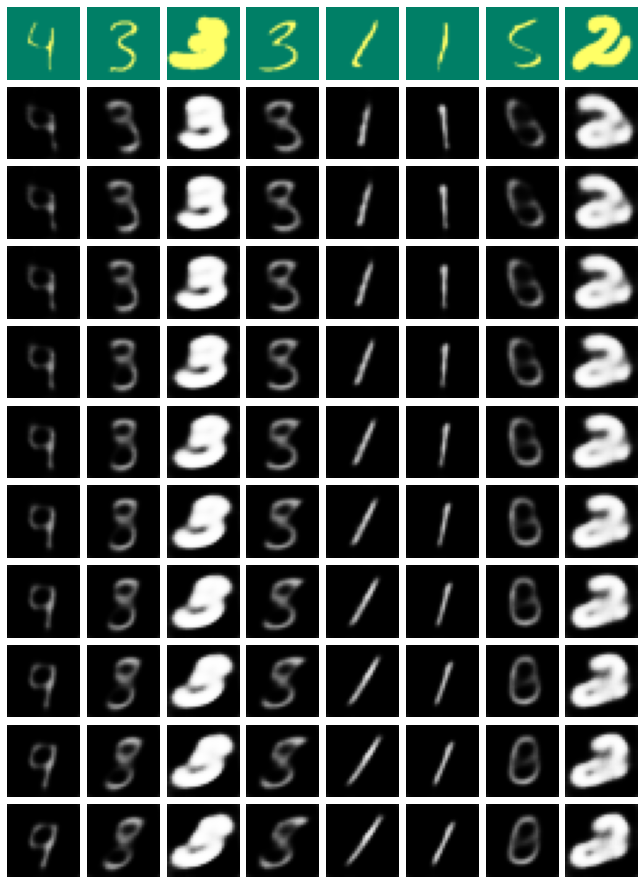

In [111]:
interpolate_and_display(model, 'slant')

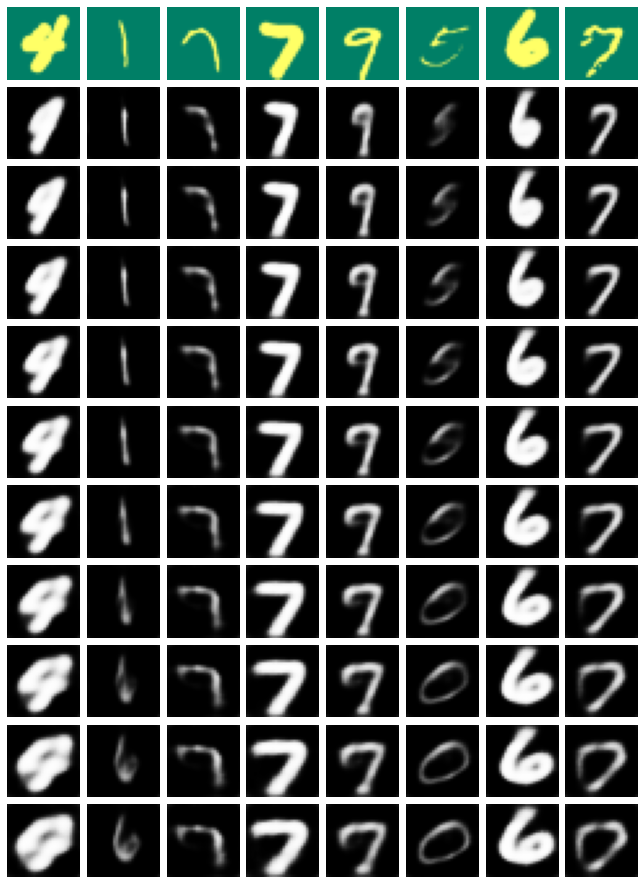

In [112]:
interpolate_and_display(model, 'width')